In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import metrics
from collections import Counter

from scipy.stats import mode
from math import factorial

import gc

In [ ]:
# This is the value difference-> if the difference in max probability between SVC and ET we will replace ET result (i.e. bacteria class) with SVC
THRESHOLD= 0.3

In [ ]:
# experimental params 

ITERATIONS = 1030
SEED = 42

PSEUDO = True

DROP_DUPS = True

# Import Data

In [ ]:
train = pd.read_csv("../input/tabular-playground-series-feb-2022/train.csv", index_col = 0) 
test = pd.read_csv("../input/tabular-playground-series-feb-2022/test.csv", index_col = 0) 
sub = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv", index_col = 0)

# Feature engineering 

In [ ]:
features = train.columns[:-1]

#### From the amazing Ambrosm 
https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense

In [ ]:
def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(s):
    w = int(s[1:s.index('T')])
    x = int(s[s.index('T')+1:s.index('G')])
    y = int(s[s.index('G')+1:s.index('C')])
    z = int(s[s.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

train_i = pd.DataFrame({col: ((train[col] + bias_of(col)) * 1000000).round().astype(int) for col in features})
test_i = pd.DataFrame({col: ((test[col] + bias_of(col)) * 1000000).round().astype(int) for col in features})

def gcd_of_all(df_i, elements=features):
    gcd = df_i[elements[0]]
    for col in elements:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

train['gcd'] = gcd_of_all(train_i)
test['gcd'] = gcd_of_all(test_i)

del train_i
del test_i

In [ ]:
train["gcd"].value_counts()

# Pseudolabels

In [ ]:
et_1 = pd.read_csv("../input/extra-trees-cv-voting/submission.csv",index_col=0)
et_2 = pd.read_csv("../input/early-ensemble/submission.csv",index_col=0)
et_3 = pd.read_csv("../input/tps-feb-2022/submission.csv",index_col=0)
ensemble = pd.DataFrame({"target": et_2["target"],"target2": et_1["target"],"target3": et_3["target"], })

In [ ]:
if PSEUDO:
    print("Adding Pseudolabels")
    index_e = ensemble[ (ensemble["target"]==ensemble["target2"]) & (ensemble["target2"]==ensemble["target3"])].index
    ensemble =ensemble.loc[index_e].drop(["target2","target3"],axis =1)

    pseudo = pd.concat([test.loc[index_e],ensemble],axis=1 )
    
    train = pd.concat([train,pseudo],axis=0).reset_index(drop=True)

# Duplicates

In [ ]:
if DROP_DUPS:
    print("Dropping Dups")
    train.drop_duplicates(keep="first", inplace=True,ignore_index=True)

In [ ]:
features_added= [col for col in train.columns if col not in features]
features = [col for col in train.columns if col not in ['target']]
features_added.remove("target")
print(list(features_added))

## ET Submission

Get submission from our best notebook, we will use this to filter the test data for slicing and prediction

In [ ]:
ET_probas = pd.read_csv("../input/tps-feb-22-bacterial-z-scoring-clustering/sub_probas.csv", index_col = 0)
ET_probas.index = test.index

ET_sub = pd.read_csv("../input/tps-feb-22-bacterial-z-scoring-clustering/submission_cv.csv", index_col = 0)
ET_sub

In [ ]:
test["target"] = ET_sub["target"]

In [ ]:
encoder = LabelEncoder()
train["target"] = encoder.fit_transform(train["target"])
test["target"] = encoder.transform(test["target"])
ET_sub["target"]= encoder.transform(ET_sub["target"])
test

ET_original = ET_sub.copy(deep = True) 

# SVC Run 

0. 'Bacteroides_fragilis', 
1. 'Campylobacter_jejuni',
1. 'Enterococcus_hirae',
1. 'Escherichia_coli',
1. 'Escherichia_fergusonii',
1. 'Klebsiella_pneumoniae', 
1. 'Salmonella_enterica',
1. 'Staphylococcus_aureus', 
1. 'Streptococcus_pneumoniae',
1. 'Streptococcus_pyogenes'

In [ ]:
model = SVC(C= 1.0, kernel = "rbf", max_iter = -1, probability=True )

def build_run_model(estimator, X_train, y_train,X_test,y_test): 
    
    estimator.fit(X_train,y_train)
    y_pred = estimator.predict(X_test)
    y_proba = estimator.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred) 
    print("Accuracy",accuracy )
    
    return accuracy, estimator, y_pred, pd.DataFrame(y_proba)

From ET misclassification on validation data 
https://www.kaggle.com/slythe/tps-feb-22-bacterial-z-scoring-clustering#Base-model

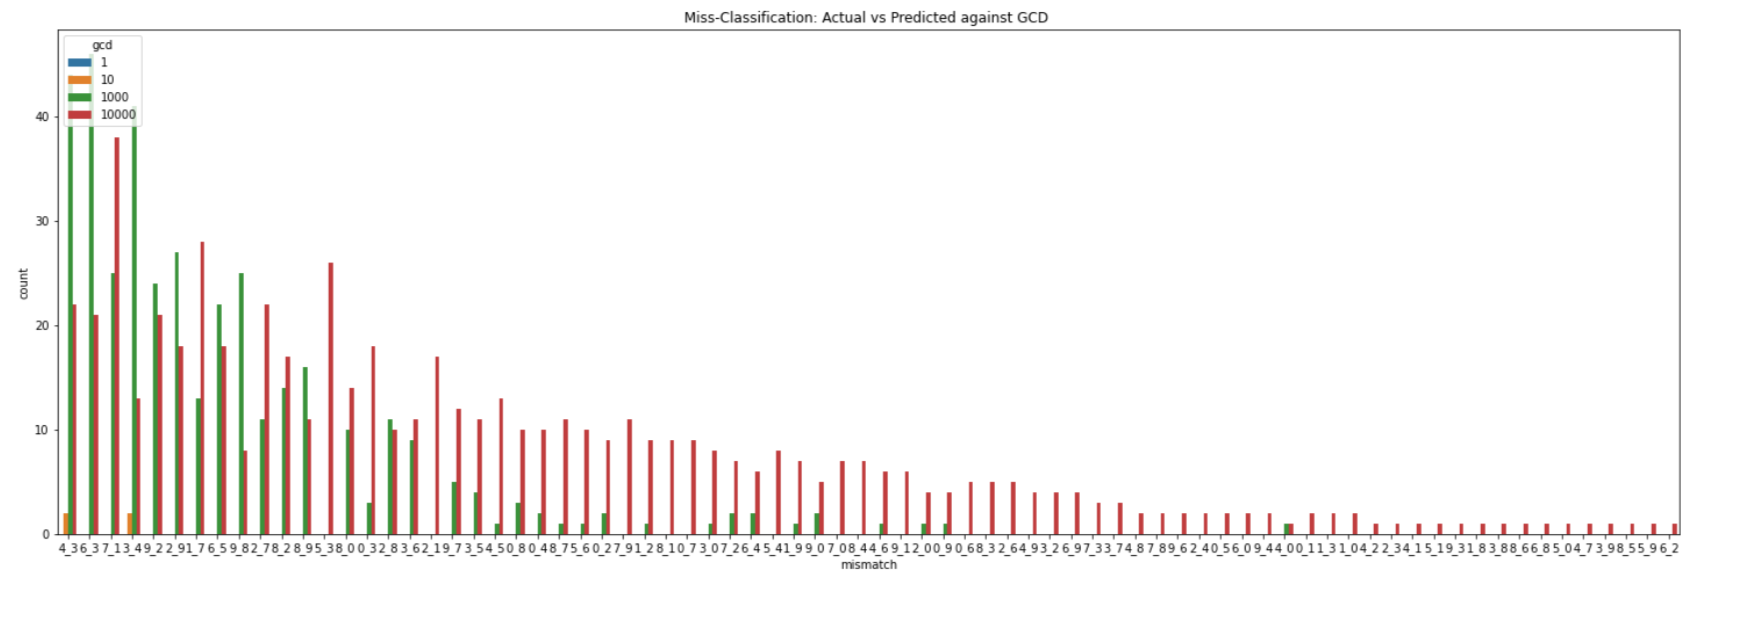

### Process 
* Run SVC model for specific bacteria pairs 
* Check max probability of SVC vs ET (get difference) 
* If difference > threshold -> replace ET target with SVC target class 

In [ ]:
for bac1,bac2 in [(4,3),(6,3),(7,1), (9,2), (6,5)]:
    print("\nbacteria",bac1, "and",bac2)
    for gcd in [1000,10000]:
        train_slice = train[((train["target"]==bac1) | (train["target"]==bac2)) & (train["gcd"]==gcd)]
        test_slice=  test[((test["target"]==bac1) | (test["target"]==bac2)) & (test["gcd"]==gcd)]

        X_train = train_slice.drop("target",axis =1)
        X_test = test_slice.drop("target",axis =1)
        y_train = train_slice["target"].apply(lambda x: 1 if x ==bac1 else 0)
        y_test = test_slice["target"].apply(lambda x: 1 if x ==bac1 else 0)

        #scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        #run SVC model
        accuracy, model, svc_preds, svc_probas = build_run_model(model, X_train, y_train,X_test,y_test)
        #print(classification_report(y_test,svc_preds))

        # check where SVC probability is greater than ET
        svc_probas.index = test_slice.index 
        
        svc_best =  svc_probas [  (svc_probas.max(axis =1).values -ET_probas.loc[test_slice.index].max(axis =1).values) > THRESHOLD]

        # Update values
        ET_sub.loc[svc_best.index, "target"] = svc_best.idxmax(axis = 1).apply(lambda x : bac1 if x ==1 else bac2).values
        print("Differences","\n",ET_original.loc[svc_best.index]["target"].value_counts()  - ET_sub.loc[svc_best.index]["target"].value_counts()) 

# Submission 

In [ ]:
final_preds = encoder.inverse_transform(ET_sub["target"].astype("int32"))
sub["target"] = final_preds
sub.to_csv("submission.csv")
sub.head()

# Visualise difference

In [ ]:
ET_original["target"] = encoder.inverse_transform(ET_original["target"].astype("int32"))
diff = ET_original["target"].value_counts()  - sub["target"].value_counts()
pd.DataFrame(diff)

In [ ]:
plt.figure(figsize= (20,8))
sns.barplot(x= pd.DataFrame(diff).index , y=pd.DataFrame(diff)["target"])
plt.xticks(rotation = "90")
plt.title("Change from ET to SVC")
plt.show()